## Tutorial notebook: Generating SimBA dataset parameters for *multiple bias subgroups* in a *binary disease classification task*

**With more than one bias subgroup in each disease class, stratification is more complicated because we need to ensure that *each* bias subgroup has the same distribution of disease and subject effects (otherwise, there are distribution shift-related biases that will also manifest in deep learning pipelines).**

**The general steps for this are:**
1. Define distribution of subject effects, such that this distribution is the same in each disease class. 
2. Define distribution of disease effects for each class.
3. Perform stratified splitting of simulated "subjects" (defined by disease + subject effects) into each bias subgroup.

Import libraries, define sampling parameters: 

In [307]:
import numpy as np
import pandas as pd
import argparse
from pathlib import Path
from numpy.random import Generator, PCG64
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from utils import merge_shuffle_data
import seaborn as sns
import matplotlib.pyplot as plt

In [308]:
SEED_D  = 7 #seed for disease class
SEED_ND = 4 #seed for non-disease class
SEED_S = 2 #seed for subject effects
TOTAL_N = 6000 #total number of samples to start with
D_FRAC = 0.5 #fraction of total samples in disease class
ISV = True
MU_D = 1 #mean of distribution for disease class
MU_ND = -1 #mean of distribution for non-disease class
SD_D = 1 #std of effect sampling dst
MU_S = 0 #mean of subject sampling dst
SD_S = 1 #std of subject sampling dst
LOWER_S = -3.5 #lower bound of subject sampling dst
UPPER_S = 3.5 #upper bound of subject sampling dst
BINS_D = 10 #number of bins for disease effect stratification
BINS_S = 10 #number of bins for subject effect stratification
TRAIN_FRAC = 0.5 #fraction of dataset to split into training set
VAL_FRAC = 0.25 #fraction of dataset to split into validation set
TEST_FRAC = 0.25 #fraction of dataset to split into test set
EXP = 'test_exp' #experiment name

Note that `TOTAL_N` will not be the final number of images in the dataset, since we will be undersampling data to maintain stratification. Therefore, some guess + check on initial value of `TOTAL_N` may be required to end up with a desired dataset size.

This code requires information about the bias subgroups to be defined within a dictionary, where the key corresponds to the bias subgroup label, and the value is a list containing two numbers:
1. the proportion of the total dataset coming from that subgroup
2. the overall fraction of the disease class contained in that subgroup. 

this dictionary represents target proportions for the dataset, and the final values may not match exactly since we will need to undersample data to maintain stratification. therefore, may require some iteration/tweaking if precise proportions are desired.


below is a sample calculation for this: 

![title](../figures/multi_bias_sample_calc.png)

In [309]:
#bias dict -> first value = proportion of total dataset coming from that group, 
#                second value = overall fraction of that group that belongs to disease class
bias_dict = {
                0: [0.290, 0.845],
                1: [0.210, 0.5],
                2: [0.210, 0.5],
                3: [0.290, 0.155]
                }

### 1. Define distribution of subject effects, such that this distribution is the same in each disease class. 

For both subject and disease effects, we define "bins" comprised of a range of values corresponding to effect magnitude along the PC subspace. To ensure that the bias subgroups are stratified by subject and disease effects, we want the desired proportion of "bias" to "no bias" samples in each bin. 

In [310]:
def get_subject_distributions(seed, mu, sd, num, d_frac, lower_bound, upper_bound, bins):
    '''
    get dataframe with subject effects for each disease class
    
    -----inputs------
    -seed: seed for deterministic random number generation
    -mu: mean value of subject effect sampling distribution
    -sd: standard deviation of subject effect sampling distribution
    -num: number of samples to generate
    -d_frac: fraction of all data defined as the disease class
    -lower_bound: lower bound of truncated gaussian distribution for subject sampling
    -upper_bound: upper bound of truncated gaussian distribution for subject sampling
    -bins: number of bins for subject effect stratification
    -----outputs-----
    -isv_nd: subject effect distribution for the non-disease class
    -isd_d: subject effect distribution for the disease_class
    '''
    #define subject effect distribution
    numpy_randomGen = Generator(PCG64(seed))
    truncnorm.random_state=numpy_randomGen

    isv_dst_mean = mu #mean value of component for generating distribution of samples
    isv_dst_sd = sd #standard deviation for generating distirbution of samples
    isv_dst_bounds = [lower_bound, upper_bound]
    isv_dst_raw = truncnorm.rvs((isv_dst_bounds[0]-isv_dst_mean)/isv_dst_sd, (isv_dst_bounds[1]-isv_dst_mean)/isv_dst_sd, loc=isv_dst_mean, scale=isv_dst_sd, size=num)
    isv_bins = pd.cut(isv_dst_raw, bins=bins, labels=False)
    s = {'isv_dst': isv_dst_raw,
         'isv_bin': isv_bins}

    isv_df = pd.DataFrame(data=s)
    w = isv_df.isv_bin.value_counts()
    bins_to_remove = w.index[w<=1].tolist()
    print('dropping {} bins from class sampling step'.format(len(bins_to_remove)))
    isv_to_split = isv_df[~isv_df['isv_bin'].isin(bins_to_remove)]
    isv_nd, isv_d = train_test_split(isv_to_split, test_size = d_frac, random_state=42, stratify=isv_to_split[['isv_bin']])

    return isv_nd, isv_d


Get dataframes for subject effect distributions for each class, ND and D:

In [311]:
isv_nd, isv_d = get_subject_distributions(SEED_S, MU_S, SD_S, TOTAL_N, D_FRAC, LOWER_S, UPPER_S, BINS_S)
NUM_D = len(isv_d)
NUM_ND = len(isv_nd)

dropping 0 bins from class sampling step


In [312]:
isv_d #example

,isv_dst,isv_bin
303,0.263475,5
2903,-0.519681,4
920,1.069543,6
2331,-0.468012,4
2957,-0.764625,3
...,...,...
1003,-0.849323,3
1211,0.167224,5
1367,-0.952694,3
1175,-0.302330,4


### 2. Define distribution of disease effects for each class.

In [313]:
def get_class_distributions(seed, mu, sd, num_samples, isv_dst, isv_bins, bins_d, bins_s, class_label):
    '''
    get dataframe with disease + subject effects for all subjects in a given class
    
    -----inputs------
    -seed: seed for deterministic random number generation
    -mu: mean value of disease effect sampling distribution
    -sd: standard deviation of disease effect sampling distribution
    -num_samples: number of samples to generate for this class
    -isv_dst: stratified subject effect distribution for this class
    -isv_bins: bin values from subject effect stratification step
    -bins_d: number of stratificatin bins for disease effects 
    -bins_s: number of stratification bins defined for subject effects
    -class_label: numeric label for this disease class
    -----outputs-----
    -df: dataframe with subject effects, disease effects, bias labels, and class labels for this disease class
    '''    
    numpy_randomGen = Generator(PCG64(seed))
    
    #generate disease effect distribution
    effect_dst_mean = mu #mean value of component for generating distribution of samples
    effect_dst_sd = sd #standard deviation for generating distribution of samples
    effect_dst_raw = numpy_randomGen.normal(effect_dst_mean, effect_dst_sd, num_samples) #get samples from disease effect distribution
    
    effect_bins = pd.cut(effect_dst_raw, bins=bins_d, labels=False)
    
    d = {'isv_dst': isv_dst,
         'effect_dst': effect_dst_raw,
         'isv_bin': isv_bins,
         'effect_bin': effect_bins}
    
    df = pd.DataFrame(data=d)
    df['both_bins'] = df['isv_bin'].astype(str) +'_' + df['effect_bin'].astype(str)
    x = df.both_bins.value_counts()
    
    #remove bins that contain less simulated :"subjects" than bias groups
    bins_to_remove = x.index[x<=len(bias_dict)].tolist() 
    print('dropping {} bins from bias sampling step'.format(len(bins_to_remove)))
    df_to_split = df[~df['both_bins'].isin(bins_to_remove)]
    return df_to_split


In this step, we get a separate dataframe for each class, containing disease effect distributions for each "subject":

In [314]:
df_to_split_D = get_class_distributions(SEED_D, MU_D, SD_D, NUM_D, isv_d['isv_dst'].values, isv_d['isv_bin'].values, BINS_D, BINS_S, 1)
df_to_split_ND = get_class_distributions(SEED_ND, MU_ND, SD_D, NUM_ND, isv_nd['isv_dst'].values, isv_nd['isv_bin'].values, BINS_D, BINS_S, 0)

dropping 26 bins from bias sampling step
dropping 24 bins from bias sampling step


In [315]:
df_to_split_D #example

,isv_dst,effect_dst,isv_bin,effect_bin,both_bins
0,0.263475,1.001230,5,5,5_5
1,-0.519681,1.298746,4,5,4_5
2,1.069543,0.725862,6,4,6_4
3,-0.468012,0.109408,4,4,4_4
4,-0.764625,0.545329,3,4,3_4
...,...,...,...,...,...
2995,-0.849323,-0.454667,3,3,3_3
2996,0.167224,0.516850,5,4,5_4
2997,-0.952694,3.015833,3,8,3_8
2998,-0.302330,-0.054555,4,3,4_3


Note that `both_bins` is just the label for the arbitrarily defined subject effect bin + the corresponding disease effect bin. 
This "composite" bin value corresponds to a range of values within a certain combination of disease + subject effects, and is important in the next step when we perform stratified undersampling. 

### 3. Perform stratified splitting of simulated "subjects" (defined by disease + subject effects) into bias subgroups, with an undersampling technique.

This is performed separately for each class. We ensure that each composite bin contains the correct proportion of each bias subgroup based on the `bias_dict`. Then, we undersample certain bias groups in each bin to get the target representation for each subgroup for that class.

#### first, we need helper functions to get information required for computing bias subgroups:

* `get_frac_list()` returns a list of values corresponding to cumulative distribution for each bias group's representation of the dataset

* `get_undersample_lists()` calculates the proportion of each bias subgroup that needs to be retained in order to end up with the target representation of bias subgroup within each class

In [316]:
def get_frac_list(bias_dict):
    frac_list = []
    for i, (k,v) in enumerate(bias_dict.items()):
        if i==0:
            frac_list.append(v[0])
        else:
            newVal = frac_list[i-1] + v[0]
            frac_list.append(newVal)
    frac_list = frac_list[:-1]
    return frac_list

In [317]:
frac_list = get_frac_list(bias_dict)
frac_list
# output: [0.29, 0.29+0.21, 0.29+0.21+0.21]

[0.29, 0.5, 0.71]

In [318]:
def get_undersample_lists(bias_dict):
    #calculate % to drop from either class to reach target representation of disease class per scanner
    #if fraction of either class is less than 50%, will need to drop from that class
    D_drop_from_class=[]
    ND_drop_from_class=[]
    drop_frac_list=[]
    for i, (k,v) in enumerate(bias_dict.items()):
        D_frac = v[1]
        if D_frac==0.5:  
            ND_drop_from_class.append(False)
            D_drop_from_class.append(False)
            drop_frac_list.append(None)
        elif D_frac<0.5: #need to drop from D class 
            ND_drop_from_class.append(False)
            D_drop_from_class.append(True)
            y=D_frac/(1-D_frac)
            drop_frac_list.append(y)
        elif D_frac>0.5: #need to drop from ND class
            ND_drop_from_class.append(True)
            D_drop_from_class.append(False)
            y=(1-D_frac)/D_frac
            drop_frac_list.append(y)
    return D_drop_from_class, ND_drop_from_class, drop_frac_list

In [319]:
drop_from_class_D, drop_from_class_ND, drop_frac_list = get_undersample_lists(bias_dict)
print(drop_from_class_D) #whether or not to drop D class from each bias subgroup
print(drop_from_class_ND) #whether or not to drop ND class from each bias subgroup
print(drop_frac_list) #target class representation for each bias group

[False, False, False, True]
[True, False, False, False]
[0.18343195266272194, None, None, 0.1834319526627219]


In [320]:
def get_bias_stratified_classes(df_to_split, frac_list, drop_from_class, drop_frac_list, disease_class):
    '''
    stratified split of disease and subject effects into bias groups for a given class
    
    df_to_split: df for a specific class containing values for each image's disease and subject effects
    frac_list: list of values corresponding to cumulative distribution for each bias group's representation of the dataset
    drop_from_class: boolean list corresponding to whether a bias subgroup needs to be undersampled for this class
    drop_frac_list: list of correspinding to target representation of this class for each bias group
    disease_class: label for this class (1=disease, 0=no disease)
    
    '''
    
    # 1. split all samples by effect + subject bin value
    
    # here, we create a dictionary for storing separate pieces of df_to_split corresponding to each value of "both_bins"
    bin_names = df_to_split.both_bins.unique()
    binDict = {elem : pd.DataFrame() for elem in bin_names}
    for key in binDict.keys():
        binDict[key] = df_to_split[:][df_to_split.both_bins == key]
    
    
    
    # 2. within each bin, perform stratified split corresponding to bias subgroup representation
    
    splitDict = {} #dictionary for storing dataframes that undergo stratified splitting within each bin
    
    # split the df for each bin into chunks corresponding to the size of each bias group defined in frac_list
    for i, (k,v) in enumerate(binDict.items()):
        lst = np.array_split(v, [int(np.round(m * len(v))) for m in frac_list]) 
        splitDict.update({k:lst})
    
    # undersample within bias groups to get desired representation of bias group within this disease class
    for i, (k,v) in enumerate(splitDict.items()): #i.e. for each bias group within each composite bin...
        lst_keep=[]
        for j in range(len(drop_frac_list)): 
            if drop_from_class[j]==True:
                lst_keep.append(np.array_split(v[j], [int(len(v[j])*drop_frac_list[j])])[0]) #store first element of split df for this scanner (corresponds to proportion of df to keep)
            else:
                lst_keep.append(v[j]) #if not dropping for this scanner, just keep original df 
        splitDict.update({k:lst_keep})
            
    
    splitList = list(splitDict.values()) #list of lists containing split dfs
    
    
    # 3. concatenate and label samples for each bias subgroup
    subgroupList = []
    for i, (k,v) in enumerate(bias_dict.items()):
        df_temp = pd.concat([item[i] for item in splitList], axis=0) #concat each column of list of lists (each col corresponds to a bias subgroup)
        df_temp['bias_label'] = k 
        df_temp['class_label'] = disease_class
        subgroupList.append(df_temp)
        
        
    # 4. combine all scanners into one df for this class  
    df_combined = pd.concat(subgroupList, axis=0)
    sns.jointplot(data=df_combined, x='isv_dst', y='effect_dst', hue='bias_label', palette='Dark2')
    plt.suptitle(f'Disease Class: {disease_class}')
    plt.show()
    
    return df_combined

We get a separate dataframe for each class:

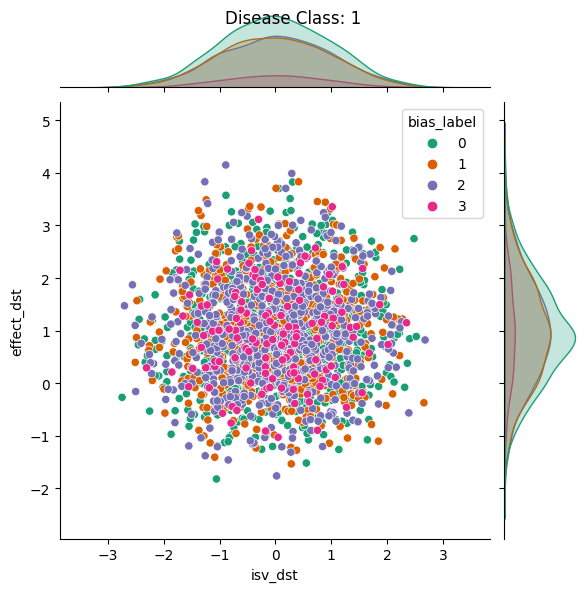

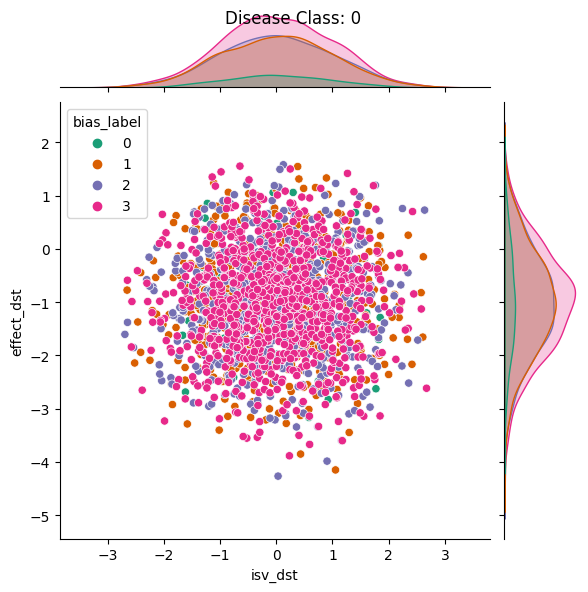

In [321]:
df_D = get_bias_stratified_classes(df_to_split_D, frac_list, drop_from_class_D, drop_frac_list, 1)
df_ND = get_bias_stratified_classes(df_to_split_ND, frac_list, drop_from_class_ND, drop_frac_list, 0)

### Combine dataframe for each class and perform stratified splits (based on subject effect, disease effect, and bias label) into train/val/test partitions:

In [322]:
def train_val_test_split(df, val_frac, test_frac, isv):
    '''
    get train/val/test splits
    '''
    
    df['strat_col'] = df['class_label'].astype(str) +'_' + df['bias_label'].astype(str) + '_' + df['effect_bin'].astype(str) + '_' + df['isv_bin'].astype(str)
    
    #remove datasets with <=2 from main df
    x = df.strat_col.value_counts()
    bins_to_remove = x.index[x<=2].tolist()
    print('dropping {} bins during training split'.format(len(bins_to_remove)))
    df_to_split = df[~df['strat_col'].isin(bins_to_remove)]
    
    #stratified train/val/test splits
    train, valtest = train_test_split(df_to_split, test_size = test_frac + val_frac, stratify=df_to_split[['strat_col']], random_state=42)
    
    #remove datasets with <=1 from valtest -> to add back to val
    y = valtest.strat_col.value_counts()
    bins_to_remove = y.index[y<=1].tolist()
    print('dropping {} bins during validation split'.format(len(bins_to_remove)))
    valtest_to_split = valtest[~valtest['strat_col'].isin(bins_to_remove)]
    
    val, test = train_test_split(valtest_to_split, test_size = (test_frac/(test_frac+val_frac)), stratify=valtest_to_split[['strat_col']], random_state=42)
    
    print('Total samples after stratification: {}'.format(len(train) + len(val) + len(test)))
    
    return train, val, test

In [323]:
df = merge_shuffle_data([df_D, df_ND])
train, val, test = train_val_test_split(df, VAL_FRAC, TEST_FRAC, ISV)

dropping 102 bins during training split
dropping 9 bins during validation split
Total samples after stratification: 4303


In [327]:
# save_dir = ...
# train.to_csv(save_dir + '/train_dst.csv')
# val.to_csv(save_dir + '/val_dst.csv')
# test.to_csv(save_dir + '/test_dst.csv')

These saved splits can now be used to generate data using `generate_data_multibias.py`.